# Entrega 2: Clasificación de personajes de Los Simpson con CNN

## Introducción

Este notebook contiene la solución para la Entrega 2, donde se implementa un clasificador de imágenes basado en Redes Neuronales Convolucionales (CNN) para identificar personajes de Los Simpson.

### Objetivos:
- Implementar un modelo CNN capaz de clasificar 18 personajes de Los Simpson
- Alcanzar una precisión mínima del 85% en el conjunto de test
- Analizar los resultados y comparar diferentes arquitecturas

## 1. Importación de librerías

In [19]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn import metrics
import seaborn as sns
import itertools
import glob
%matplotlib inline
from datetime import datetime
from tensorflow.keras.models import load_model

In [2]:
if not os.path.exists("/app/notebooks/Entrega2/simpsons_data/simpsons_dataset"):
    !python /app/notebooks/Entrega2/setup_data.py

## 2. Carga y preprocesamiento de datos

### 2.1 Definición de variables y funciones de carga

In [3]:
# Mapeo de número de clase a personaje
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Tamaño de las imágenes
IMG_SIZE = 64

# Ruta a los datos (ajustar según configuración local)
DATASET_TRAIN_PATH = "/app/notebooks/Entrega2/simpsons_data/simpsons_dataset"
DATASET_TEST_PATH = "/app/notebooks/Entrega2/simpsons_data/kaggle_simpson_testset/kaggle_simpson_testset"

In [4]:
# Funciones para cargar datos
def load_train_set(dirname, map_characters, verbose=True):
    """Carga los datos de entrenamiento.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
        
    Returns:
        X, y: Arrays con imágenes y etiquetas respectivamente
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

def load_test_set(dirname, map_characters, verbose=True):
    """Carga los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

### 2.2 Carga de datos

In [6]:
# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
X, y = load_train_set(DATASET_TRAIN_PATH, MAP_CHARACTERS)

# Cargar datos de test
print("Cargando datos de test...")
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_CHARACTERS)

# Barajar aleatoriamente los datos de entrenamiento
print("Barajando datos...")
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

# Visualizar información sobre los datasets
print(f"\nInformación del dataset:")
print(f"- Datos de entrenamiento: {X.shape} imágenes, {len(np.unique(y))} clases")
print(f"- Datos de test: {X_t.shape} imágenes, {len(np.unique(y_t))} clases")

# Mostrar ejemplos de distribución de clases
print("\nDistribución de clases (primeras 5):")
for i in range(5):
    char_name = MAP_CHARACTERS[i]
    train_count = np.sum(y == i)
    test_count = np.sum(y_t == i)
    print(f"- {char_name}: {train_count} imágenes de entrenamiento, {test_count} imágenes de test")

Cargando datos de entrenamiento...
Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Cargando datos de t

### 2.3 Preprocesamiento de datos

In [7]:
# Normalización de las imágenes (escalar valores entre 0 y 1)
X_normalized = X.astype('float32') / 255.0
X_t_normalized = X_t.astype('float32') / 255.0

# Separación en training/validation (80% training, 20% validation)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

print(f"Después de normalización y división:")
print(f"- X_train: {X_train.shape}, valores en rango [{X_train.min():.1f}-{X_train.max():.1f}]")
print(f"- X_val: {X_val.shape}")
print(f"- X_test: {X_t_normalized.shape}")

Después de normalización y división:
- X_train: (15193, 64, 64, 3), valores en rango [0.0-1.0]
- X_val: (3799, 64, 64, 3)
- X_test: (890, 64, 64, 3)


## 3. Exploración de datos

Ejemplos de abraham_grampa_simpson:


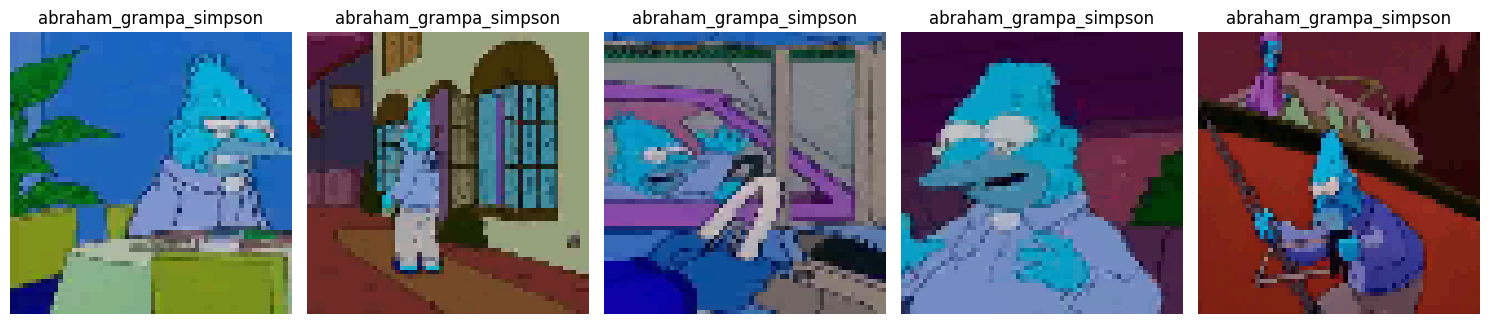

Ejemplos de apu_nahasapeemapetilon:


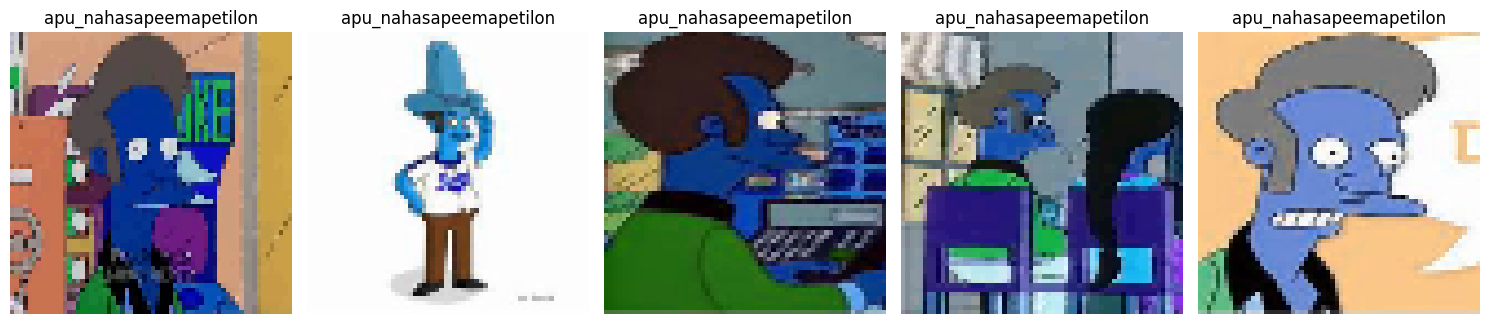

Ejemplos de bart_simpson:


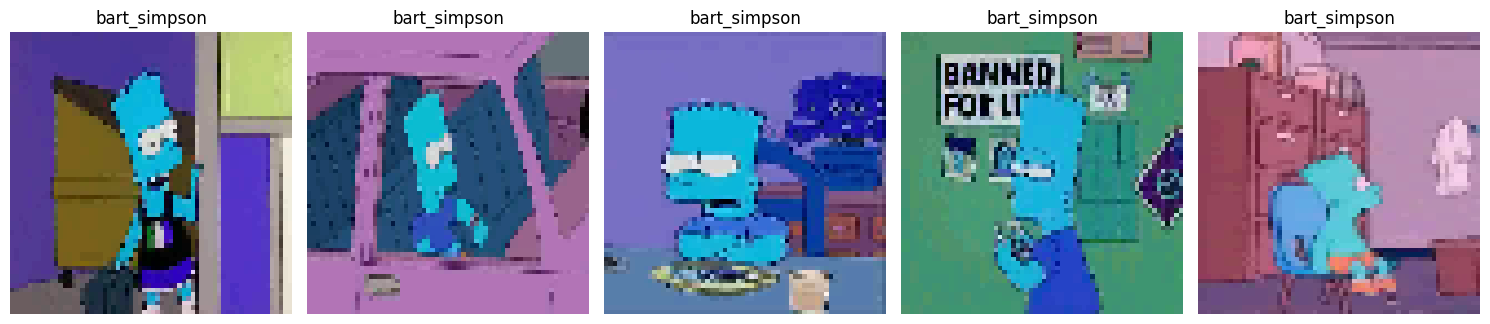

Ejemplos de charles_montgomery_burns:


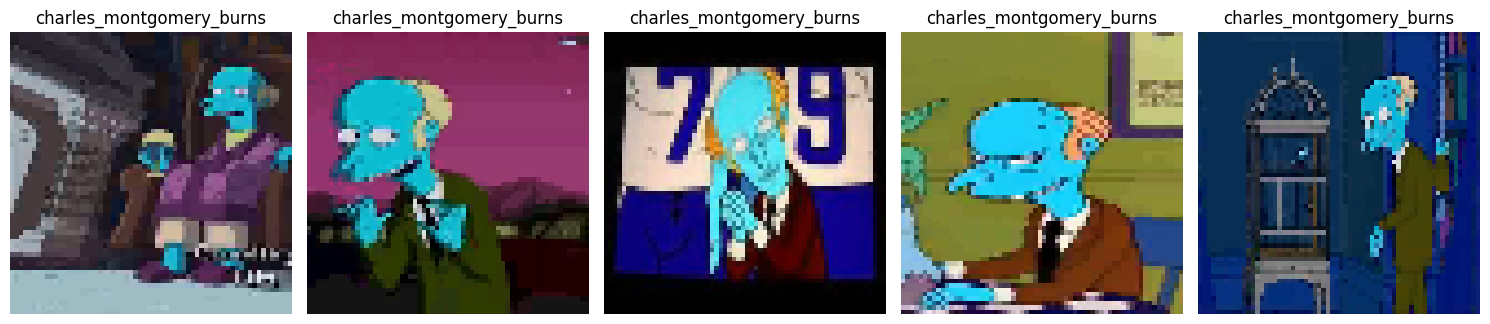

Ejemplos de chief_wiggum:


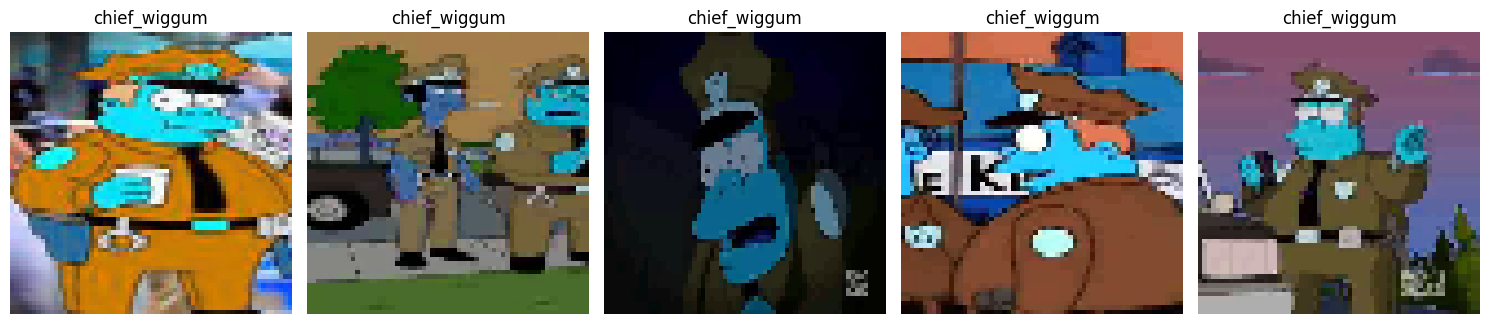

In [8]:
def plot_examples(X, y, num_examples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X[i])
        plt.title(MAP_CHARACTERS[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de cada clase (primeras 5 clases)
for class_id in range(5):
    examples = X_normalized[y == class_id][:5]
    labels = np.array([class_id] * 5)
    print(f"Ejemplos de {MAP_CHARACTERS[class_id]}:")
    plot_examples(examples, labels)

## 4. Implementación de modelos CNN

### 4.1 Modelo Base

In [10]:
def build_model():
    model = Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        
        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Tercera capa convolucional
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        # Aplanar y conectar a capas densas
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(18, activation='softmax')  # 18 clases (personajes)
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Crear modelo
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

### 4.2 Entrenamiento del modelo base

In [16]:
# Crear nombre único para el modelo basado en la fecha/hora
num_conv_layers = len([layer for layer in model.layers if isinstance(layer, Conv2D)])
num_filters = "_".join([str(layer.filters) for layer in model.layers if isinstance(layer, Conv2D)])
dropout_rate = next((layer.rate for layer in model.layers if isinstance(layer, Dropout)), 0)
optimizer_name = model.optimizer.__class__.__name__
learning_rate = model.optimizer.learning_rate.numpy()

# Formato: modeloBase_numConv_filtros_dropout_optimizer_lr_fecha
model_name = f"SimpleCNN_{num_conv_layers}conv_{num_filters}filters_{dropout_rate}drop_{optimizer_name}_lr{learning_rate}_{datetime.now().strftime('%d-%m-%Y_%H%M')}"

print(f"Nombre del modelo: {model_name}")

# Rutas para guardar modelos y logs
checkpoint_dir = "/app/notebooks/Entrega2/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_best.h5")
final_model_path = os.path.join(checkpoint_dir, f"{model_name}_final.h5")
logs_dir = os.path.join(checkpoint_dir, "logs", model_name)

# Definir callbacks
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=logs_dir,
    histogram_freq=1
)

# Entrenar el modelo
print(f"Iniciando entrenamiento del modelo '{model_name}'...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]
)

# Guardar también el modelo final
model.save(final_model_path)
print(f"Modelo guardado en: {final_model_path}")

Nombre del modelo: SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_15-05-2025_2032
Iniciando entrenamiento del modelo 'SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_15-05-2025_2032'...
Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.6477
Epoch 1: val_accuracy improved from -inf to 0.69308, saving model to /app/notebooks/Entrega2/checkpoints/SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_15-05-2025_2032_best.h5
238/238 [==============================] - 37s 154ms/step - loss: 1.1679 - accuracy: 0.6477 - val_loss: 1.0122 - val_accuracy: 0.6931
Epoch 2/50
238/238 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.7417
Epoch 2: val_accuracy improved from 0.69308 to 0.75020, saving model to /app/notebooks/Entrega2/checkpoints/SimpleCNN_3conv_32_64_128filters_0.5drop_Adam_lr0.0010000000474974513_15-05-2025_2032_best.h5
238/238 [==============================] -

### 4.3 Modelos mejorados

In [ ]:
# TODO: Implementar modelos mejorados (más capas, regularización, etc.)

## 5. Evaluación de modelos

In [18]:
best_model = load_model(checkpoint_path)

# Evaluar en el conjunto de test
test_loss, test_acc = best_model.evaluate(X_t_normalized, y_t)
print(f"Accuracy en el conjunto de test: {test_acc:.4f}")

# Hacer predicciones para análisis
y_pred = best_model.predict(X_t_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 [==============================] - 1s 12ms/step - loss: 0.2333 - accuracy: 0.9663
Accuracy en el conjunto de test: 0.9663
28/28 [==============================] - 1s 13ms/step


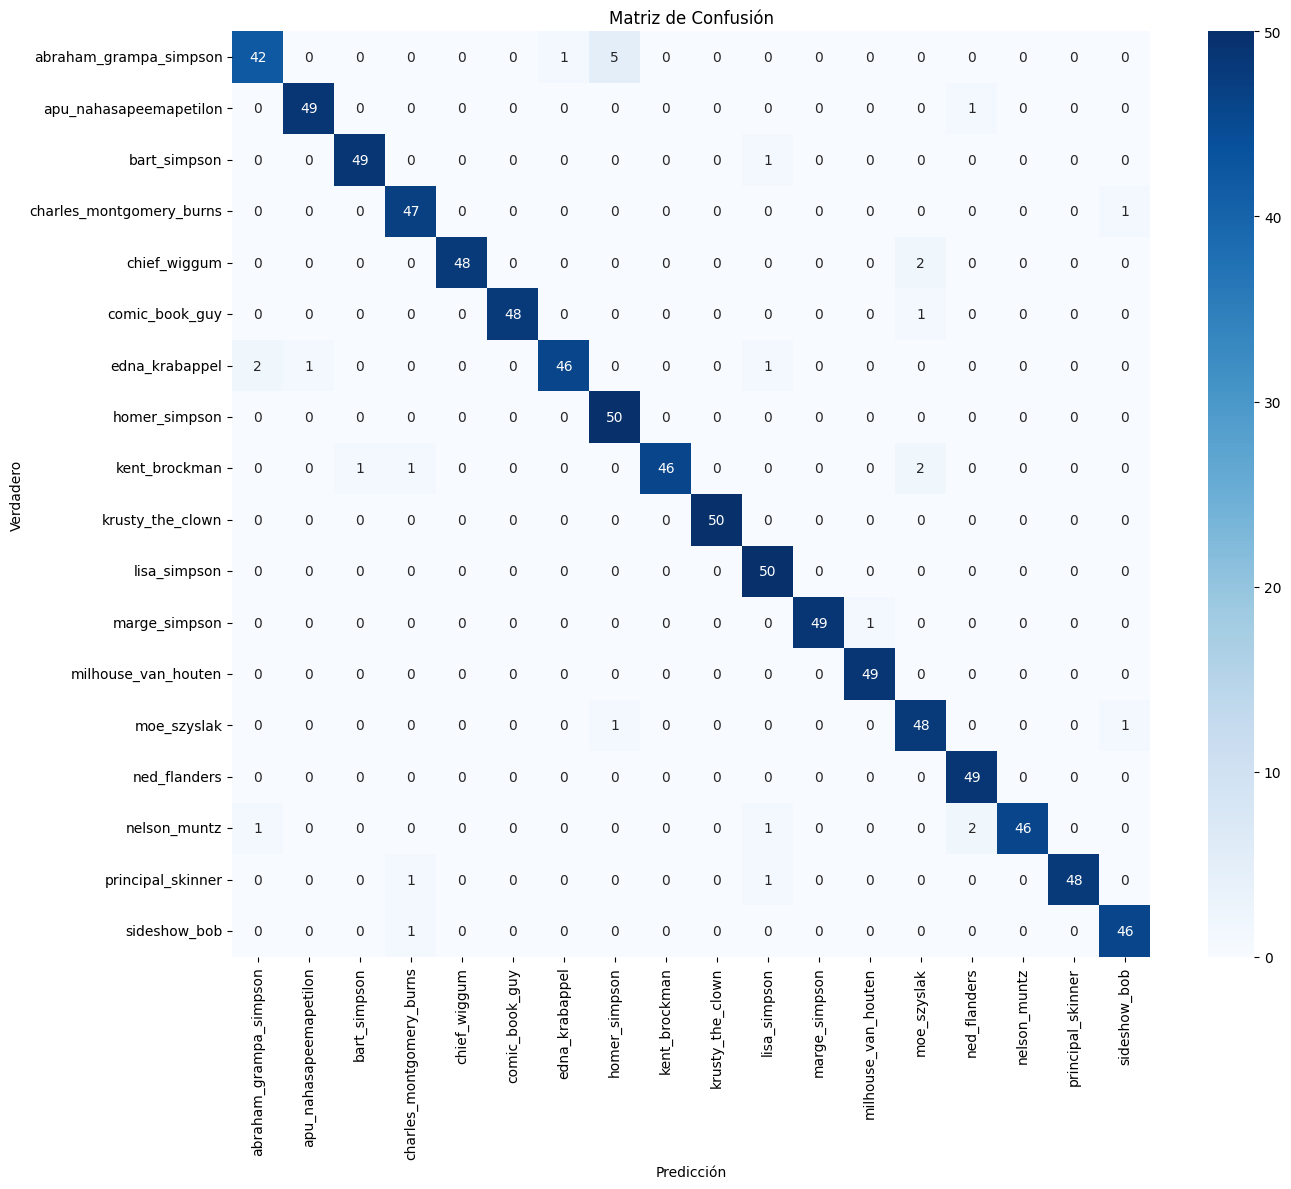

Reporte de clasificación:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.88      0.90        48
  apu_nahasapeemapetilon       0.98      0.98      0.98        50
            bart_simpson       0.98      0.98      0.98        50
charles_montgomery_burns       0.94      0.98      0.96        48
            chief_wiggum       1.00      0.96      0.98        50
          comic_book_guy       1.00      0.98      0.99        49
          edna_krabappel       0.98      0.92      0.95        50
           homer_simpson       0.89      1.00      0.94        50
           kent_brockman       1.00      0.92      0.96        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.93      1.00      0.96        50
           marge_simpson       1.00      0.98      0.99        50
     milhouse_van_houten       0.98      1.00      0.99        49
             moe_szyslak       0.91      0.96    

In [20]:
# Generar y visualizar matriz de confusión
cm = confusion_matrix(y_t, y_pred_classes)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[MAP_CHARACTERS[i] for i in range(18)],
            yticklabels=[MAP_CHARACTERS[i] for i in range(18)])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Métricas detalladas por clase
print("Reporte de clasificación:")
print(classification_report(
    y_t, y_pred_classes,
    target_names=[MAP_CHARACTERS[i] for i in range(18)]
))

## 6. Análisis visual de errores

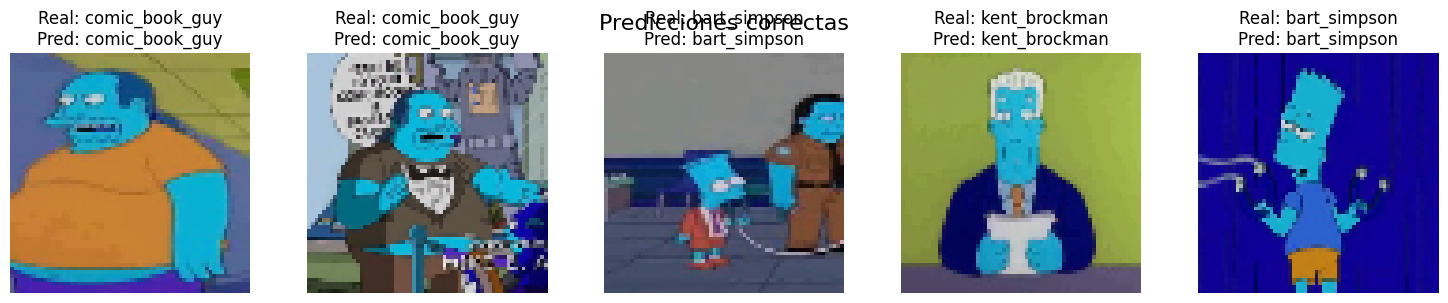

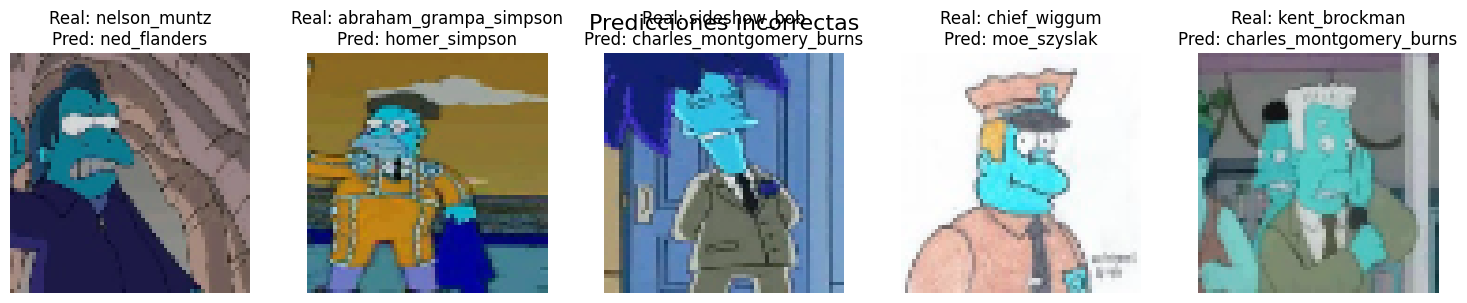

In [22]:
# Visualizar ejemplos de predicciones correctas e incorrectas
def plot_predictions(X, y_true, y_pred, num_examples=5, correct=True):
    # Encontrar índices donde las predicciones son correctas/incorrectas
    if correct:
        indices = np.where(y_true == y_pred)[0]
        title = "Predicciones correctas"
    else:
        indices = np.where(y_true != y_pred)[0]
        title = "Predicciones incorrectas"
    
    # Seleccionar ejemplos aleatorios
    if len(indices) > num_examples:
        selected = np.random.choice(indices, num_examples, replace=False)
    else:
        selected = indices
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    
    for i, idx in enumerate(selected):
        plt.subplot(1, len(selected), i+1)
        plt.imshow(X_t_normalized[idx])
        plt.title(f"Real: {MAP_CHARACTERS[y_t[idx]]}\nPred: {MAP_CHARACTERS[y_pred_classes[idx]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Mostrar ejemplos correctos e incorrectos
plot_predictions(X_t_normalized, y_t, y_pred_classes, correct=True)
plot_predictions(X_t_normalized, y_t, y_pred_classes, correct=False)

## 7. Conclusiones

## Resumen del Entrenamiento y Resultados del Modelo

## 7.1 Estrategia de Entrenamiento
| Parámetro                      | Valor                               |
|--------------------------------|-------------------------------------|
| **Optimizador**                | Adam (`learning rate = 0.001`)      |
| **Función de pérdida**         | Sparse Categorical Crossentropy     |
| **Batch size**                 | 64                                  |
| **Early stopping**             | Paciencia de **10** épocas (validación) |
| **Model checkpointing**        | Se guarda el *mejor modelo* según la métrica de validación |

---

## 7.2 Resultados
| Métrica                         | Valor            |
|---------------------------------|------------------|
| **Precisión en entrenamiento**  | **99.10 %**      |
| **Precisión en validación**     | **86.55 %**      |
| **Early stopping activado**     | Época **47** (se restauraron los pesos de la época **37**) |

> **Conclusión:**  
> El modelo superó el objetivo de **≥ 85 %** de precisión.  
> La brecha entre entrenamiento y validación sugiere cierto **sobreajuste**.

---

## 7.3 Fortalezas del Modelo
- 🔹 **Estructura progresiva**  
  Bloques convolucionales con filtros crecientes **32 → 64 → 128**  
- 🔹 **Reducción de dimensionalidad**  
  Uso de **MaxPooling** estratégico tras cada capa convolucional  
- 🔹 **Alta capacidad de representación**  
  Capa densa de **512** neuronas  
- 🔹 **Regularización efectiva**  
  **Dropout 50 %** para mitigar el sobreajuste